# Forecasting Weather with SARIMA
## 1 . Environment

In [1]:
# scipy
import scipy
print('scipy: %s' % scipy.__version__)

# numpy
import numpy as np
print('numpy: %s' % np.__version__)

# matplotlib
import matplotlib.pylab as plt
print('matplotlib: %s' % plt.__version__)

# seaborn
import seaborn as sns
print('seaborn: %s' % sns.__version__)

# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)

# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)

# statsmodels
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
print('statsmodels: %s' % statsmodels.__version__)

#pymongo
import pymongo
import pprint
print('pymongo: %s' % pymongo.__version__)

#json
from bson import json_util, ObjectId
from pandas.io.json import json_normalize
import json

import itertools
import warnings

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

scipy: 0.19.1
numpy: 1.13.3
matplotlib: 1.13.3
seaborn: 0.8.0
pandas: 0.20.3
sklearn: 0.19.1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


statsmodels: 0.8.0
pymongo: 3.4.0


## 2. Extracting Data and Transforming Data

In [2]:
# Cria conexão com o Banco de Dados
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

# Cria Instância do Banco de Dados
db = client.AgroAnalyticsDatum

#Obtem Id da Cidade
#city_info = pd.DataFrame(list(db.cities.find({'name': "São Paulo"})))
#city_info

In [3]:
#Obtem Estações da Cidade
stations_info = pd.DataFrame(list(db.meteo_data_weather_stations.find({'city_id': ObjectId('59867b595718ddc0b8efee3b')})))
stations_info

""


In [4]:
# Extrai dados Climáticos da Estação Selecionada
weather = list(db.meteo_data_weather_data.find({'weather_station_id': ObjectId('598f58415718dd578b4c8255')}))
weather_normalized = pd.io.json.json_normalize(weather)
df_weather = pd.DataFrame(weather_normalized[['analysis_date', 'weather_forecast.med_temp']])
df_weather = df_weather.set_index('analysis_date')
ts_weather = df_weather['2000-01-01':'2017-08-11'].groupby(pd.TimeGrouper(freq='MS')).mean()
ts_weather.head()

,weather_forecast.med_temp
analysis_date,
2000-01-01,22.806452
2000-02-01,22.586207
2000-03-01,21.774194
2000-04-01,20.833333
2000-05-01,18.032258


In [5]:
n_sample = ts_weather.shape[0]

# Cria amostra de treinamento e de teste antes de realizar a análise

n_train=int(0.94*n_sample)+1
n_forecast=n_sample-n_train
#ts_df
ts_train = ts_weather.iloc[:n_train]['weather_forecast.med_temp']
ts_test = ts_weather.iloc[n_train:]['weather_forecast.med_temp']
print(ts_train.shape)
print(ts_test.shape)
print("Training Series:", "\n", ts_train.tail(), "\n")
print("Testing Series:", "\n", ts_test.head())

(200,)
(12,)
Training Series: 
 analysis_date
2016-04-01    24.033333
2016-05-01    18.419355
2016-06-01    15.966667
2016-07-01    18.096774
2016-08-01    18.580645
Freq: MS, Name: weather_forecast.med_temp, dtype: float64 

Testing Series: 
 analysis_date
2016-09-01    19.366667
2016-10-01    21.290323
2016-11-01    21.400000
2016-12-01    23.870968
2017-01-01    23.774194
Freq: MS, Name: weather_forecast.med_temp, dtype: float64


### 3. Setting a Baseline with Naive Forecast

In [108]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# walk-forward validation
history = [x for x in ts_train]
predictions = list()
for i in range(len(ts_test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = ts_test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
mse = mean_squared_error(ts_test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=18.581, Expected=19.367
>Predicted=19.367, Expected=21.290
>Predicted=21.290, Expected=21.400
>Predicted=21.400, Expected=23.871
>Predicted=23.871, Expected=23.774
>Predicted=23.774, Expected=25.000
>Predicted=25.000, Expected=22.710
>Predicted=22.710, Expected=20.600
>Predicted=20.600, Expected=19.226
>Predicted=19.226, Expected=18.067
>Predicted=18.067, Expected=16.839
>Predicted=16.839, Expected=17.636
RMSE: 1.501


### 4. Model Identification (SARIMA Model Determination)

In [16]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

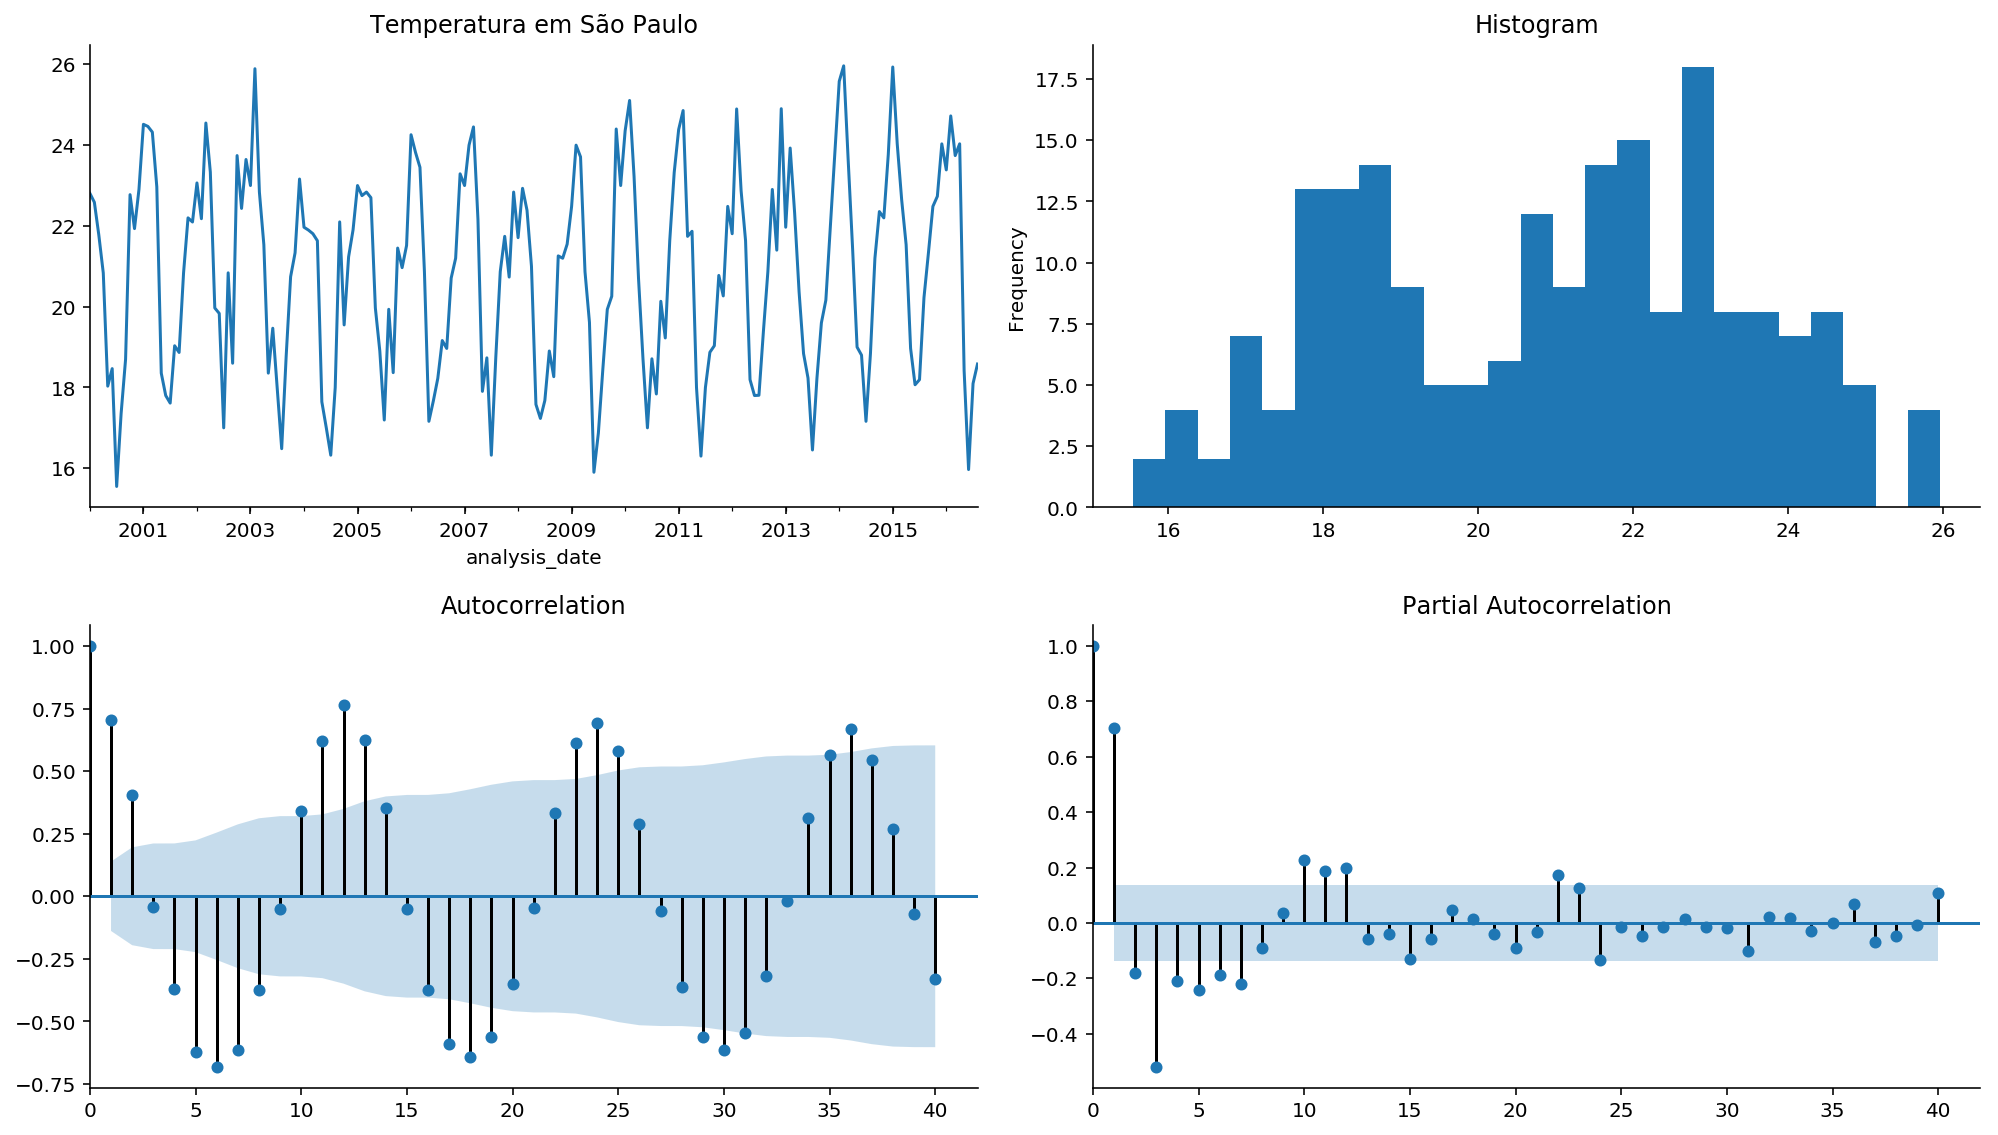

In [17]:
tsplot(ts_train, title='Temperatura em São Paulo', lags=40);

In [9]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 5)
d = range(0, 1)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 0, 3, 12)
SARIMAX: (0, 0, 2) x (0, 0, 4, 12)


In [10]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_param = None
best_param_seasonal = None
best_result = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            if best_result is None:
                best_param = param
                best_param_seasonal = param_seasonal
                best_result = results
            elif results.aic < best_result.aic :
                best_param = param
                best_param_seasonal = param_seasonal
                best_result = results
            
            print('ARIMA{}x{} - AIC:{} - BIC:{}'.format(param, param_seasonal, results.aic, results.bic))
        except:
            continue
            
print(' BEST : ARIMA{}x{} - AIC:{} - BIC:{}'.format(best_param, best_param_seasonal, best_result.aic, best_result.bic))

ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1462.1776928174822 - BIC:1468.7743275505784
ARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:1220.146778996459 - BIC:1230.0417310961031
ARIMA(0, 0, 0)x(0, 0, 3, 12) - AIC:1037.0457332898275 - BIC:1050.2390027560195
ARIMA(0, 0, 0)x(0, 0, 4, 12) - AIC:964.6116314008323 - BIC:981.1032182335724
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:683.8029467940679 - BIC:690.399581527164
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:590.6711516919659 - BIC:600.56610379161
ARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC:555.843030190059 - BIC:569.0362996562512
ARIMA(0, 0, 0)x(1, 0, 3, 12) - AIC:521.0426001852906 - BIC:537.5341870180307
ARIMA(0, 0, 0)x(1, 0, 4, 12) - AIC:472.00152061556 - BIC:491.79142481484826
ARIMA(0, 0, 0)x(2, 0, 0, 12) - AIC:603.6219772665972 - BIC:613.5169293662414
ARIMA(0, 0, 0)x(2, 0, 1, 12) - AIC:558.8350320467509 - BIC:572.0283015129431
ARIMA(0, 0, 0)x(2, 0, 2, 12) - AIC:546.3084796411947 - BIC:562.8000664739349
ARIMA(0, 0, 0)x(2, 0, 3, 12) - AIC:512.9861574886413 - BIC:532.7760616879295

ARIMA(0, 0, 4)x(1, 0, 3, 12) - AIC:529.8985725988151 - BIC:559.5834288977475
ARIMA(0, 0, 4)x(1, 0, 4, 12) - AIC:471.3827391424784 - BIC:504.36591280795875
ARIMA(0, 0, 4)x(2, 0, 0, 12) - AIC:606.9595511224702 - BIC:630.0477726883065
ARIMA(0, 0, 4)x(2, 0, 1, 12) - AIC:574.3129109989159 - BIC:600.6994499313001
ARIMA(0, 0, 4)x(2, 0, 2, 12) - AIC:581.7113249536742 - BIC:611.3961812526065
ARIMA(0, 0, 4)x(2, 0, 3, 12) - AIC:517.206094646005 - BIC:550.1892683114854
ARIMA(0, 0, 4)x(2, 0, 4, 12) - AIC:472.10723165268337 - BIC:508.38872268471175
ARIMA(0, 0, 4)x(3, 0, 0, 12) - AIC:532.9268136849547 - BIC:559.313352617339
ARIMA(0, 0, 4)x(3, 0, 1, 12) - AIC:531.8061391914616 - BIC:561.490995490394
ARIMA(0, 0, 4)x(3, 0, 2, 12) - AIC:514.528987318058 - BIC:547.5121609835384
ARIMA(0, 0, 4)x(3, 0, 3, 12) - AIC:509.18305260300065 - BIC:545.464543635029
ARIMA(0, 0, 4)x(3, 0, 4, 12) - AIC:451.0290346899337 - BIC:490.6088430885102
ARIMA(0, 0, 4)x(4, 0, 0, 12) - AIC:474.78299736859935 - BIC:504.4678536675317

ARIMA(1, 0, 3)x(3, 0, 0, 12) - AIC:526.8444995852514 - BIC:553.2310385176356
ARIMA(1, 0, 3)x(3, 0, 1, 12) - AIC:510.0129305773931 - BIC:539.6977868763254
ARIMA(1, 0, 3)x(3, 0, 2, 12) - AIC:509.96985980587186 - BIC:542.9530334713522
ARIMA(1, 0, 3)x(3, 0, 3, 12) - AIC:491.01691278411033 - BIC:527.2984038161387
ARIMA(1, 0, 3)x(3, 0, 4, 12) - AIC:451.34744995684173 - BIC:490.9272583554182
ARIMA(1, 0, 3)x(4, 0, 0, 12) - AIC:464.8694432823227 - BIC:494.55429958125507
ARIMA(1, 0, 3)x(4, 0, 1, 12) - AIC:460.8681362000532 - BIC:493.85130986553355
ARIMA(1, 0, 3)x(4, 0, 2, 12) - AIC:459.71641162769515 - BIC:495.99790265972354
ARIMA(1, 0, 3)x(4, 0, 3, 12) - AIC:457.49946243797416 - BIC:497.07927083655056
ARIMA(1, 0, 3)x(4, 0, 4, 12) - AIC:456.39394554812554 - BIC:499.27207131325
ARIMA(1, 0, 4)x(0, 0, 0, 12) - AIC:764.4606032882193 - BIC:784.2505074875075
ARIMA(1, 0, 4)x(0, 0, 1, 12) - AIC:676.983921145931 - BIC:700.0721427117674
ARIMA(1, 0, 4)x(0, 0, 2, 12) - AIC:631.7635002973379 - BIC:658.150039

ARIMA(2, 0, 2)x(4, 0, 2, 12) - AIC:455.94791735170054 - BIC:492.2294083837289
ARIMA(2, 0, 2)x(4, 0, 3, 12) - AIC:454.76263583865216 - BIC:494.3424442372286
ARIMA(2, 0, 2)x(4, 0, 4, 12) - AIC:457.28816316784435 - BIC:500.1662889329688
ARIMA(2, 0, 3)x(0, 0, 0, 12) - AIC:778.2018300184643 - BIC:797.9917342177525
ARIMA(2, 0, 3)x(0, 0, 1, 12) - AIC:684.6431919355846 - BIC:707.7314135014209
ARIMA(2, 0, 3)x(0, 0, 2, 12) - AIC:636.0596889578633 - BIC:662.4462278902475
ARIMA(2, 0, 3)x(0, 0, 3, 12) - AIC:598.5944641414901 - BIC:628.2793204404225
ARIMA(2, 0, 3)x(0, 0, 4, 12) - AIC:579.4672875640904 - BIC:612.4504612295707
ARIMA(2, 0, 3)x(1, 0, 0, 12) - AIC:660.0436807767246 - BIC:683.1319023425609
ARIMA(2, 0, 3)x(1, 0, 1, 12) - AIC:585.4454712840358 - BIC:611.83201021642
ARIMA(2, 0, 3)x(1, 0, 2, 12) - AIC:556.4761057486369 - BIC:586.1609620475692
ARIMA(2, 0, 3)x(1, 0, 3, 12) - AIC:501.6443556990432 - BIC:534.6275293645235
ARIMA(2, 0, 3)x(1, 0, 4, 12) - AIC:500.0398617904806 - BIC:536.321352822509

ARIMA(3, 0, 2)x(0, 0, 4, 12) - AIC:604.6007083505007 - BIC:637.5838820159811
ARIMA(3, 0, 2)x(1, 0, 0, 12) - AIC:654.9465033213028 - BIC:678.0347248871391
ARIMA(3, 0, 2)x(1, 0, 1, 12) - AIC:583.5782914430275 - BIC:609.9648303754118
ARIMA(3, 0, 2)x(1, 0, 2, 12) - AIC:550.1404455157578 - BIC:579.8253018146902
ARIMA(3, 0, 2)x(1, 0, 3, 12) - AIC:502.14903816368627 - BIC:535.1322118291666
ARIMA(3, 0, 2)x(1, 0, 4, 12) - AIC:507.25911880867915 - BIC:543.5406098407076
ARIMA(3, 0, 2)x(2, 0, 0, 12) - AIC:593.0784312613234 - BIC:619.4649701937077
ARIMA(3, 0, 2)x(2, 0, 1, 12) - AIC:549.2812302033988 - BIC:578.9660865023311
ARIMA(3, 0, 2)x(2, 0, 2, 12) - AIC:543.3216947379179 - BIC:576.3048684033984
ARIMA(3, 0, 2)x(2, 0, 3, 12) - AIC:498.05748142009014 - BIC:534.3389724521186
ARIMA(3, 0, 2)x(2, 0, 4, 12) - AIC:470.5988978311061 - BIC:510.1787062296826
ARIMA(3, 0, 2)x(3, 0, 0, 12) - AIC:516.6333781699439 - BIC:546.3182344688762
ARIMA(3, 0, 2)x(3, 0, 1, 12) - AIC:500.76714720771145 - BIC:533.750320873

ARIMA(4, 0, 1)x(2, 0, 1, 12) - AIC:546.7793424588401 - BIC:576.4641987577725
ARIMA(4, 0, 1)x(2, 0, 2, 12) - AIC:540.767564942493 - BIC:573.7507386079733
ARIMA(4, 0, 1)x(2, 0, 3, 12) - AIC:511.64585222961625 - BIC:547.9273432616446
ARIMA(4, 0, 1)x(2, 0, 4, 12) - AIC:468.7950096569315 - BIC:508.37481805550794
ARIMA(4, 0, 1)x(3, 0, 0, 12) - AIC:513.9384449392707 - BIC:543.623301238203
ARIMA(4, 0, 1)x(3, 0, 1, 12) - AIC:502.5228388136653 - BIC:535.5060124791457
ARIMA(4, 0, 1)x(3, 0, 2, 12) - AIC:497.598320855794 - BIC:533.8798118878224
ARIMA(4, 0, 1)x(3, 0, 3, 12) - AIC:497.69079167033533 - BIC:537.2706000689118
ARIMA(4, 0, 1)x(3, 0, 4, 12) - AIC:456.6207038154146 - BIC:499.49882958053905
ARIMA(4, 0, 1)x(4, 0, 0, 12) - AIC:460.1833057789937 - BIC:493.1664794444741
ARIMA(4, 0, 1)x(4, 0, 1, 12) - AIC:453.4549983968693 - BIC:489.7364894288977
ARIMA(4, 0, 1)x(4, 0, 2, 12) - AIC:454.3653461222908 - BIC:493.9451545208673
ARIMA(4, 0, 1)x(4, 0, 3, 12) - AIC:452.57473813850856 - BIC:495.45286390363

In [6]:
mod = sm.tsa.statespace.SARIMAX(ts_train, order=(1,0,0), seasonal_order=(4,0,1,12), enforce_stationarity=False, enforce_invertibility=False)
sarima_fit1 = mod.fit()
print(sarima_fit1.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:          weather_forecast.med_temp   No. Observations:                  200
Model:             SARIMAX(1, 0, 0)x(4, 0, 1, 12)   Log Likelihood                -223.589
Date:                            Mon, 27 Nov 2017   AIC                            461.178
Time:                                    19:19:50   BIC                            484.267
Sample:                                01-01-2000   HQIC                           470.522
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1479      0.087      1.695      0.090      -0.023       0.319
ar.S.L12       0.7219      0.101   

### 5. Model Diagnostic Checking

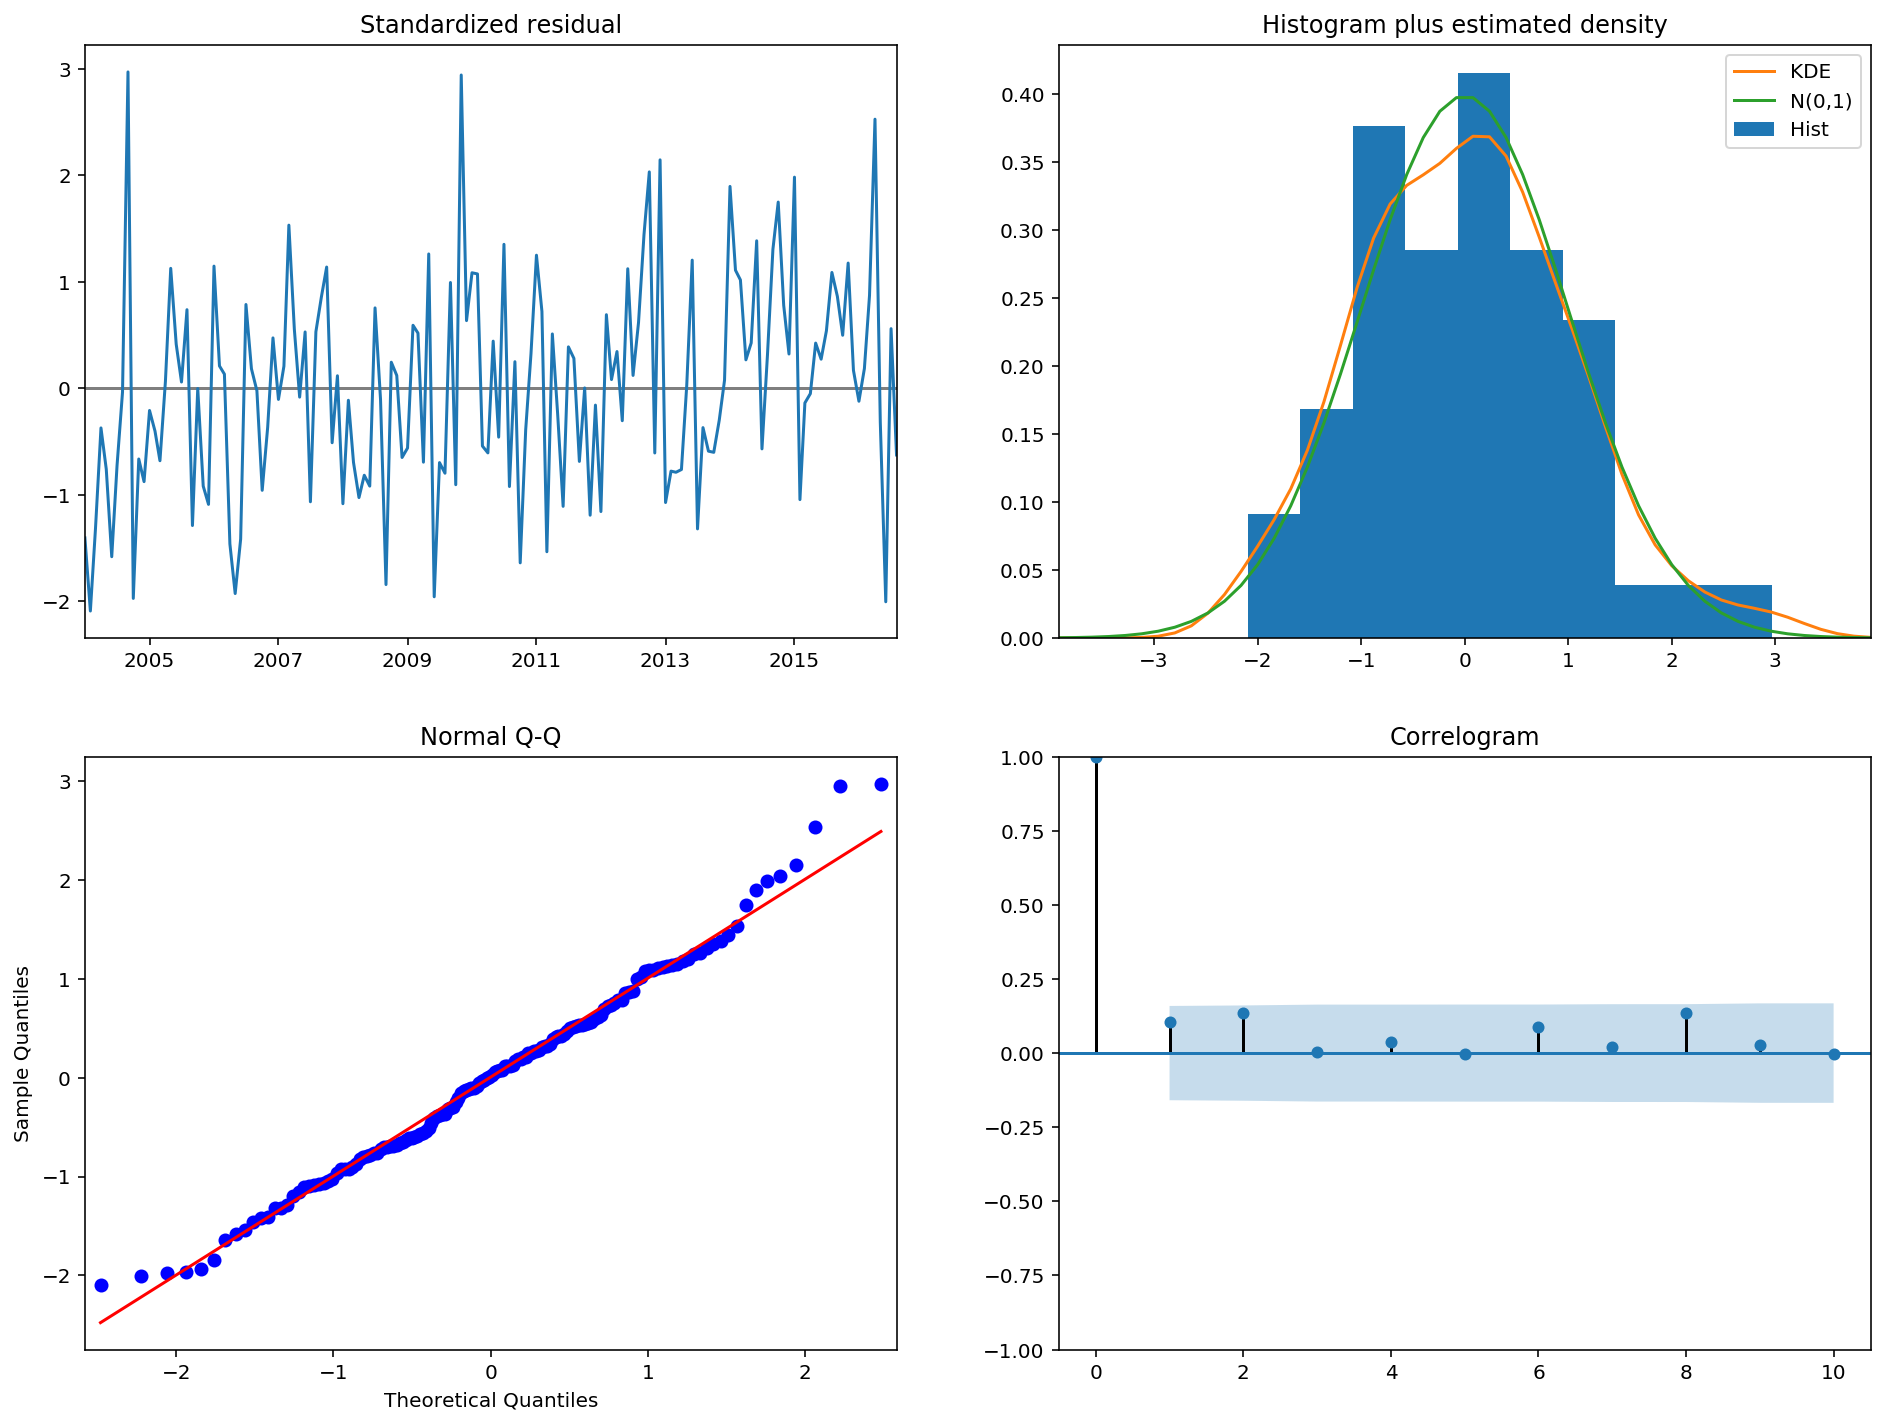

In [87]:
# Model Diagnostic

sarima_fit1.plot_diagnostics(figsize=(16, 12));

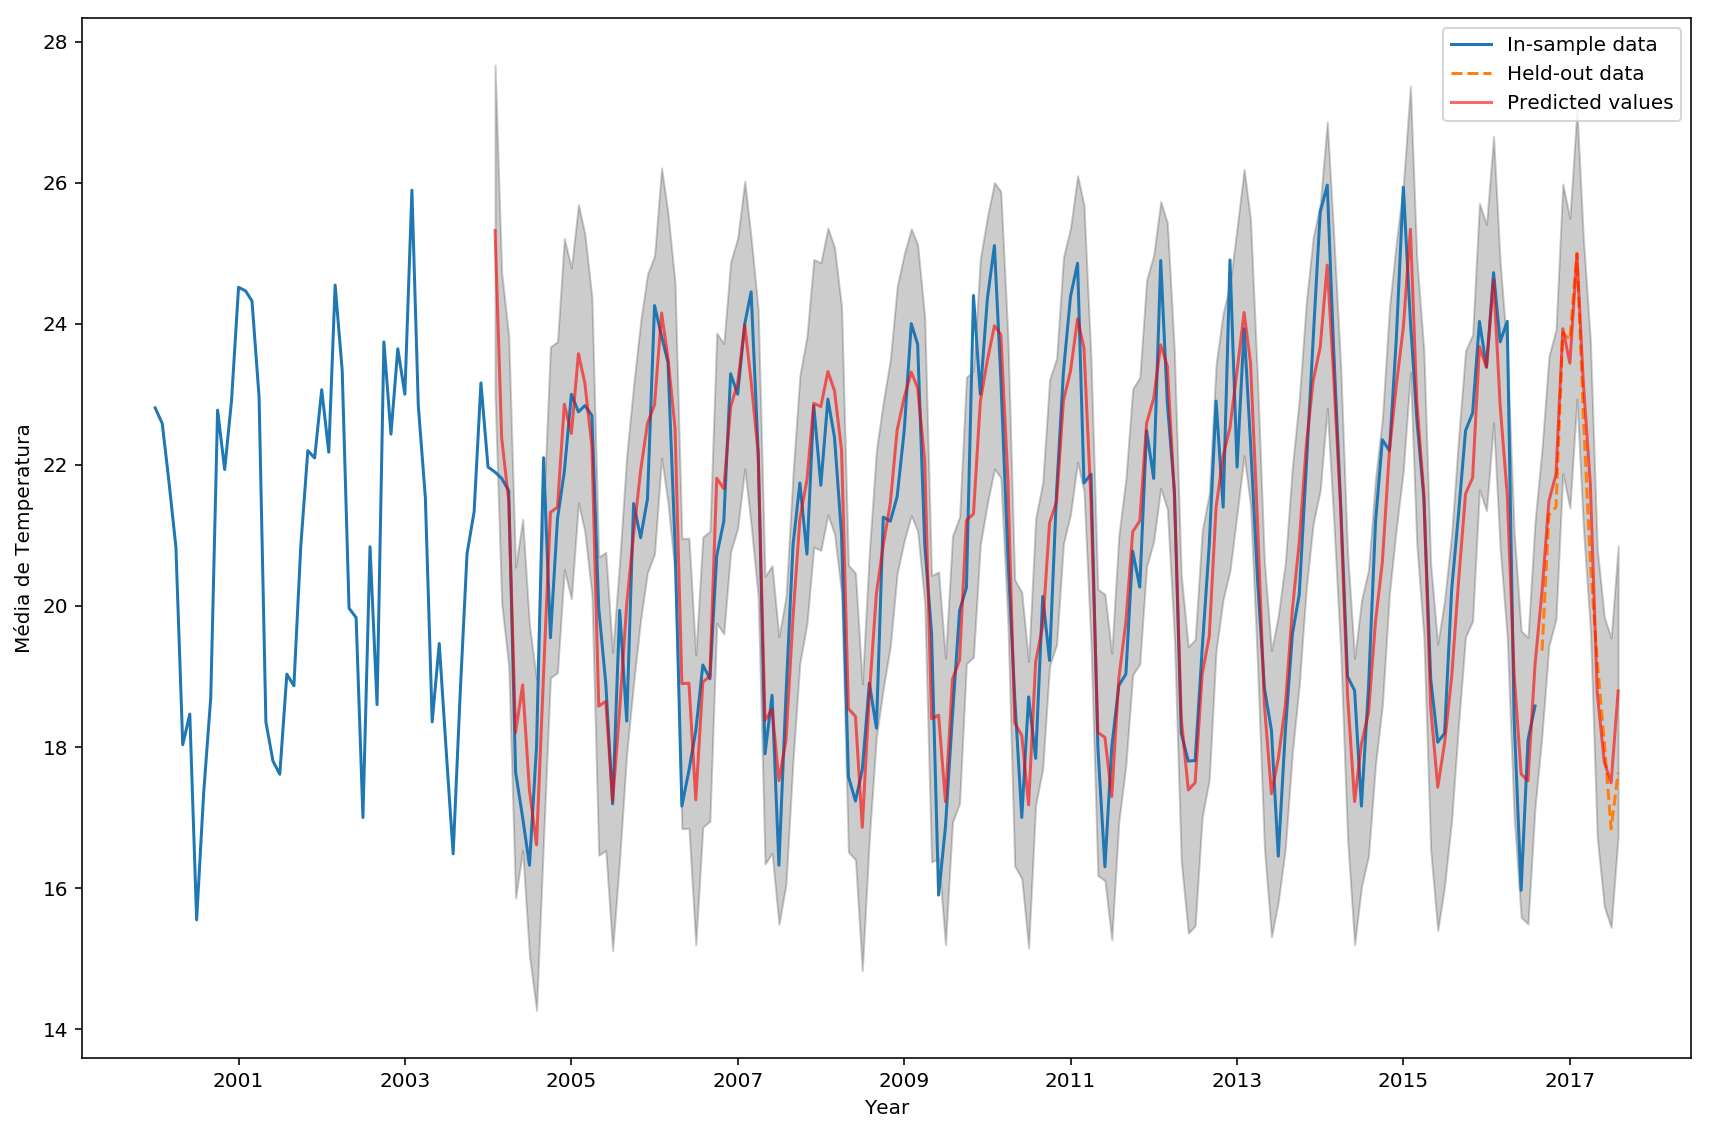

In [93]:
# Step 5: Do a 14-step ahead forecast

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = ts_train.index[sarima_fit1.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = sarima_fit1.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)
ax1.set_xlabel("Year")
ax1.set_ylabel("Média de Temperatura")
ax1.legend(loc='best');
fig.tight_layout();

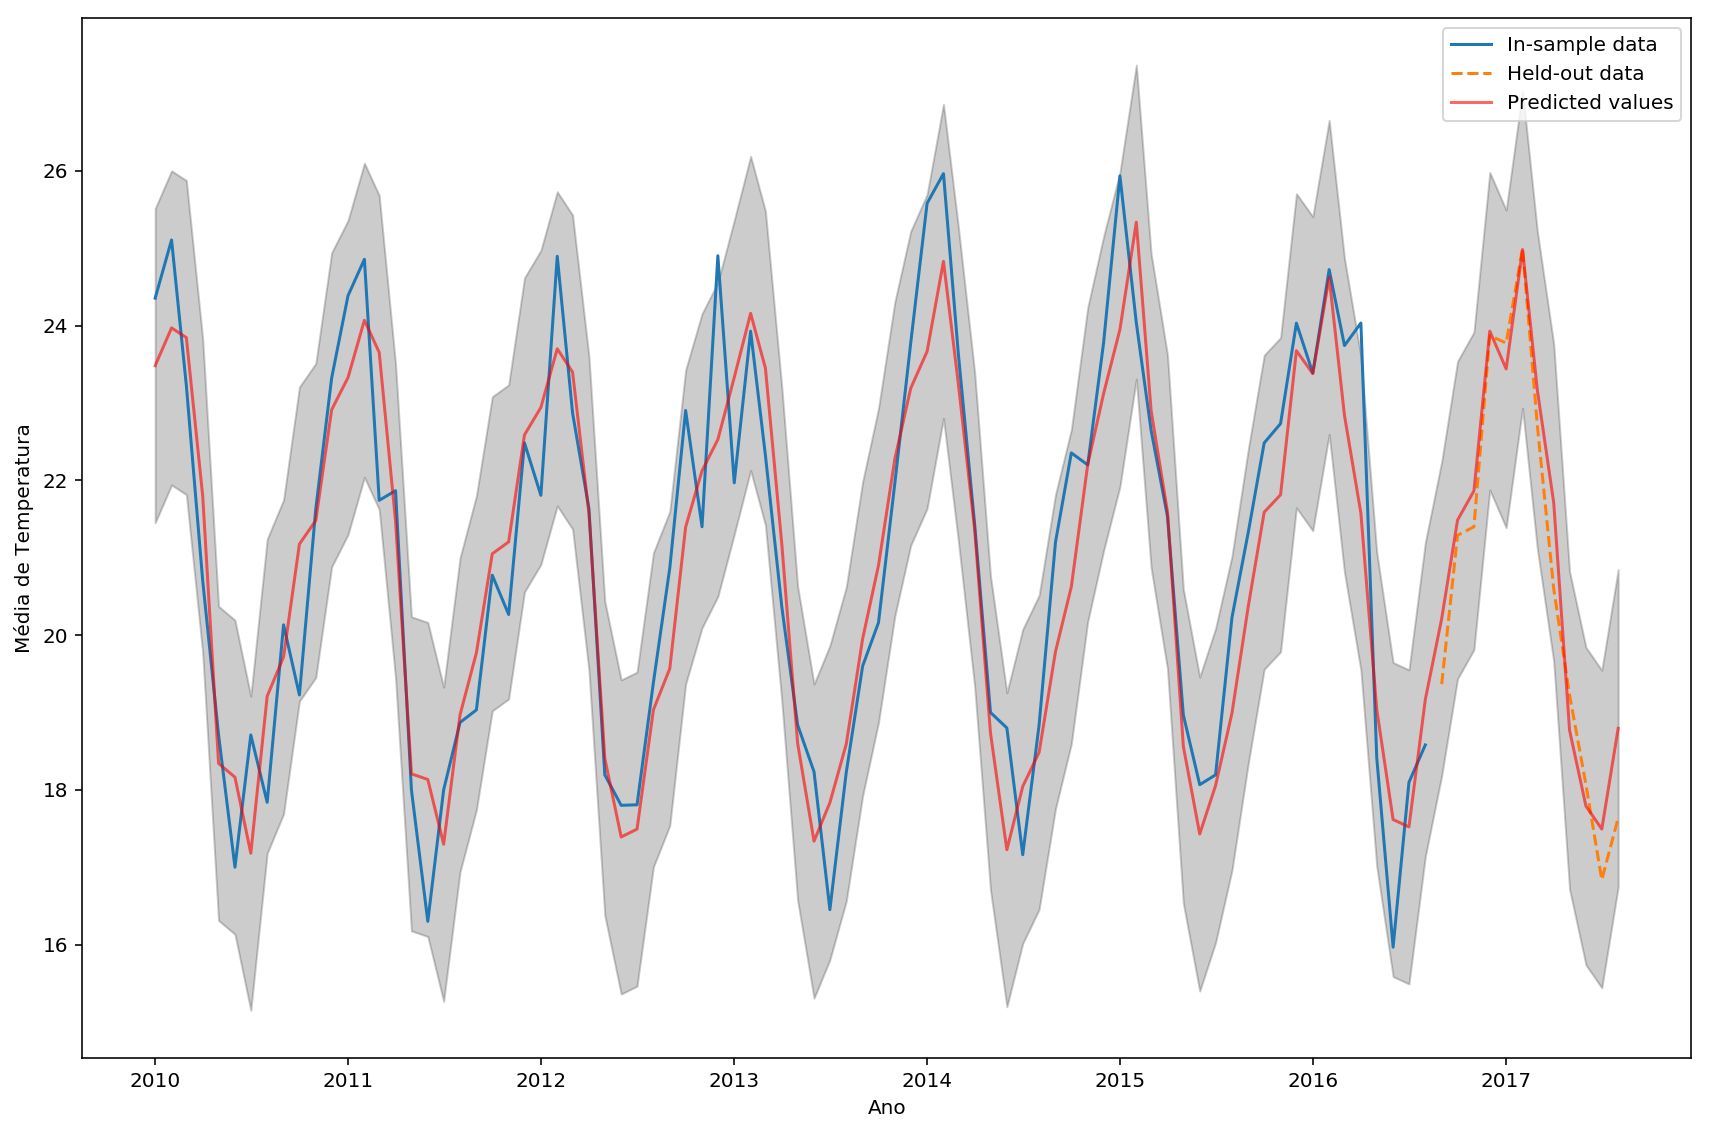

In [9]:
# Step 5: Do a 14-step ahead forecast

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train['2010-01-01':], label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test['2010-01-01':], label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = ts_train.index[sarima_fit1.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = sarima_fit1.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean['2010-01-01':], 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci['2010-01-01':].index,
                 pred_ci['2010-01-01':].iloc[:, 0],
                 pred_ci['2010-01-01':].iloc[:, 1], color='k', alpha=.2)
ax1.set_xlabel("Ano")
ax1.set_ylabel("Média de Temperatura")
ax1.legend(loc='best');
fig.tight_layout();

In [100]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    '''Mean Absolute Scaled Error
    https://en.wikipedia.org/wiki/Mean_absolute_scaled_error
    '''
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

In [105]:
# Training Set

rmse = get_rmse(ts_train, pred_mean.ix[ts_train.index])
print("RMSE: ", rmse)

mape = get_mape(ts_train, pred_mean.ix[ts_train.index])
print("MAPE: ", mape)

RMSE:  1.07621166107
MAPE:  4.155081028603547


In [106]:
# Test Set

rmse = get_rmse(ts_test, pred_mean.ix[ts_test.index])
print("RMSE: ", rmse)

mape = get_mape(ts_test, pred_mean.ix[ts_test.index])
print("MAPE: ", mape)

RMSE:  0.618203724536
MAPE:  2.578822900265104


SARIMAX(4, 0, 0)x(4, 0, 0, 12)

RMSE:  0.813337434644
MAPE:  3.3939037468247726
MASE:  1.1059525104814474

SARIMAX(4, 0, 0)x(4, 0, 1, 12)

RMSE:  0.676981237209
MAPE:  2.73454440008735
MASE:  1.090699686878555

SARIMAX(2, 0, 0)x(4, 0, 1, 12)

RMSE:  0.657343209285
MAPE:  2.7211105876339077
MASE:  1.073704021444059

SARIMAX(1, 0, 1)x(4, 0, 1, 12)

RMSE:  0.644923624871
MAPE:  2.609791106852062
MASE:  1.0834256987454955

SARIMAX(1, 0, 0)x(4, 0, 1, 12)

RMSE:  0.618203724536
MAPE:  2.578822900265104
MASE:  1.066539570691728